# Copyright Netherlands eScience Center <br>
** Function     : Energy budget - AMET (ERAI, MERRA2) & OMET (ORAS4) ** <br>
** Author       : Yang Liu ** <br>
** First Built  : 2018.09.18 ** <br>
** Last Update  : 2018.09.18 ** <br>
Description  : This script serves to investigate the compensation between energy transport in the atmosphere and ocean. It works with AMET and OMET estimated from ERA-Interim and ORAS4. The full energy budget of the Arctic is inspected here to account for the flow of energy and the residuals.<br>
Return Values : jpeg <br>
Caveat!         : The AMET is computed as the residual of net flux at TOA and surface. <br>
For all the flux generated by ECMWF model, **downward is positive** (regardless of the standard name). <br>
While for the flux in MERRA2, the **positive sign** for each variable varies:<br>
* Net shortwave radiation at surface - downward <br>
* Net shortwave radiation at TOA - downward <br>
* Net longwave radiation at surface - downward <br>
* Upwelling longwave radiation at TOA - upward <br>
* Total latent energy flux - upward <br>
* Sensible heat flux - upward <br>


In [1]:
%matplotlib inline

import sys
sys.path.append("/home/yang/NLeSC/Computation_Modeling/Bjerknes/Scripts/META")
import numpy as np
import scipy
from scipy import stats
from netCDF4 import Dataset
import matplotlib
import matplotlib.pyplot as plt
import os
import meta.statistics
import meta.visualizer

Initialization - Start with location of input and extraction of variables
Time span of each product:
- **ERA-Interim** 1979 - 2016
- **MERRA2**      1980 - 2016
- **JRA55**       1979 - 2015
- **ORAS4**       1958 - 2017
- **GLORYS2V3**   1993 - 2014
- **SODA3**       1980 - 2015

In [2]:
# constants
constant = {'g' : 9.80616,      # gravititional acceleration [m / s2]
            'R' : 6371009,      # radius of the earth [m]
            'cp': 1004.64,      # heat capacity of air [J/(Kg*K)]
            'Lv': 2264670,      # Latent heat of vaporization [J/Kg]
            'R_dry' : 286.9,    # gas constant of dry air [J/(kg*K)]
            'R_vap' : 461.5,    # gas constant for water vapour [J/(kg*K)]
            'HoF' : 334,        # heat of fusion of ice [KJ/Kg] 
            'rho_ice' : 0.91    # density of sea ice [g/cm3]
            }

In [3]:
if __name__=="__main__":
    # sample
    ################################   Input zone  ######################################
    # specify data path
    datapath = '/home/yang/workbench/Core_Database_AMET_OMET_reanalysis/warehouse_met'
    datapath_ERAI_fields = '/home/yang/workbench/Core_Database_AMET_OMET_reanalysis/ERAI/regression'
    output_path = '/home/yang/NLeSC/Computation_Modeling/Bjerknes/Compensation/MET_leadlag/stat_erai_oras_layer/budget'
    #####################################################################################
    print ('*********************** extract variables *************************')
    dataset_ERAI_fields_SIC_SST_SLP = Dataset(os.path.join(datapath_ERAI_fields,
                                              'surface_ERAI_monthly_regress_1979_2016.nc'))
    dataset_ERAI_AMET = Dataset(os.path.join(datapath,
                                             'era_model_subdaily_1979_2016_amet.nc'))
    dataset_ORAS4_OMET = Dataset(os.path.join(datapath,
                                              'oras_model_monthly_1958_2017_omet.nc'))
    dataset_ORAS4_OHC = Dataset(os.path.join(datapath,
                                             'oras_model_monthly_1958_2017_ohc.nc'))
    dataset_ERAI_fields_flux = Dataset(os.path.join(datapath_ERAI_fields,
                                                    'surface_erai_monthly_regress_1979_2017_radiation.nc'))
    # extract time series from 1979 to 2016
    # from 20N - 90N
    # 3D fields [year, month, lat]
    # since OMET is from 20N - 90N, AMET is from 90N to 20N, we have to reverse it
    # for interpolation, x should be monotonically increasing
    AMET_int_ERAI = dataset_ERAI_AMET.variables['E_total_int'][:]/1000 # from Tera Watt to Peta Watt
    # 4D fields [year, month, level, lat]
    # downward is positive for all the fluxes
    rad_short_toa_ERAI = dataset_ERAI_fields_flux.variables['tsr'][:-1,:,:,:]
    rad_long_toa_ERAI = dataset_ERAI_fields_flux.variables['ttr'][:-1,:,:,:]
    rad_short_surf_ERAI = dataset_ERAI_fields_flux.variables['ssr'][:-1,:,:,:]
    rad_long_surf_ERAI = dataset_ERAI_fields_flux.variables['str'][:-1,:,:,:]
    SFlux_sensible_ERAI = dataset_ERAI_fields_flux.variables['sshf'][:-1,:,:,:]
    SFlux_latent_ERAI = dataset_ERAI_fields_flux.variables['slhf'][:-1,:,:,:]
    # calculate total net energy flux at TOA/surface
    net_flux_surf_ERAI = rad_short_surf_ERAI + rad_long_surf_ERAI + SFlux_sensible_ERAI + SFlux_latent_ERAI
    net_flux_toa_ERAI = rad_short_toa_ERAI + rad_long_toa_ERAI
    # save memory
    del rad_short_toa_ERAI, rad_long_toa_ERAI, rad_short_surf_ERAI, rad_long_surf_ERAI
    del SFlux_sensible_ERAI, SFlux_latent_ERAI
    # 3D fields [year, month, lat]
    OMET_int_ORAS4 = dataset_ORAS4_OMET.variables['E_int'][21:-1,:,180:]/1000 # from Tera Watt to Peta Watt # start from 1979
    OMET_atl_int_ORAS4 = dataset_ORAS4_OMET.variables['E_atl_int'][21:-1,:,180:]/1000
    OMET_pac_int_ORAS4 = dataset_ORAS4_OMET.variables['E_pac_int'][21:-1,:,180:]/1000
    # 3D fields [year, month, lat]
    OHC_int_ORAS4 = dataset_ORAS4_OHC.variables['OHC_int'][21:-1,:,180:]/1000 # from Tera Joule to Peta Joule 
    OHC_atl_int_ORAS4 = dataset_ORAS4_OHC.variables['OHC_atl_int'][21:-1,:,180:]/1000 # start from 1979
    # 3D fields [year, month, lat]
    SIC_ERAI = dataset_ERAI_fields_SIC_SST_SLP.variables['ci'][:]
    SIC_ERAI_mask = np.ma.getmaskarray(SIC_ERAI[0,:,:])
    #SIC_ERAI[SIC_ERAI_mask==True] = 0
    # other dimensions
    year_ORAS4 = dataset_ORAS4_OMET.variables['year'][21:-1]    # from 1979 to 2016
    year_ERAI = dataset_ERAI_AMET.variables['year']
    latitude_OMET_ORAS4 = dataset_ORAS4_OMET.variables['latitude_aux'][180:]
    latitude_AMET_ERAI = dataset_ERAI_AMET.variables['latitude'][:]
    latitude_fields_ERAI = dataset_ERAI_fields_flux.variables['latitude'][:]
    longitude_fields_ERAI = dataset_ERAI_fields_flux.variables['longitude'][:]    
    # area weighted surface flux
    net_flux_surf_ERAI_area = np.zeros(net_flux_surf_ERAI.shape, dtype=float) # unit W
    net_flux_toa_ERAI_area = np.zeros(net_flux_toa_ERAI.shape, dtype=float)
    #size of the grid box
    dx = 2 * np.pi * constant['R'] * np.cos(2 * np.pi * latitude_fields_ERAI /
                                            360) / len(longitude_fields_ERAI) 
    dy = np.pi * constant['R'] / len(latitude_fields_ERAI)
    for i in np.arange(len(latitude_fields_ERAI)):
        # change the unit to terawatt
        net_flux_surf_ERAI_area[:,:,i,:] = net_flux_surf_ERAI[:,:,i,:] * dx[i] * dy / 1E+12
        net_flux_toa_ERAI_area[:,:,i,:] = net_flux_toa_ERAI[:,:,i,:] * dx[i] * dy / 1E+12
    # modify the mask of sea ice and calculate the area of ice
    SIC_ERAI_mask_3D = np.repeat(SIC_ERAI_mask[np.newaxis,:,:],len(year_ERAI)*12,0)
    SIC_ERAI_area = np.zeros(SIC_ERAI.shape, dtype=float)
    for i in np.arange(len(latitude_fields_ERAI)):
        SIC_ERAI_area[:,i,:] = SIC_ERAI[:,i,:] * dx[i] * dy
    SIC_ERAI_area[SIC_ERAI_mask_3D==True] = 0

*********************** extract variables *************************


In [16]:
    # check the latitude
    print (latitude_OMET_ORAS4[53:55])
    print (latitude_AMET_ERAI[40])
    print (latitude_fields_ERAI[40])

[60.018433 60.629475]
60.0
60.0


In [4]:
    # calculate the tendency of OHC
    # apply the central scheme
    OHC_int_ORAS4_series = OHC_int_ORAS4.reshape(len(year_ORAS4)*12,
                                                 len(latitude_OMET_ORAS4))
    OHC_tend_int_ORAS4 = np.zeros(OHC_int_ORAS4_series.shape,dtype=float)
    for i in np.arange(len(year_ORAS4)*12-2):
        # skip the first and the last value
        OHC_tend_int_ORAS4[i+1,:] = ((OHC_int_ORAS4_series[i+2,:]
                                     - OHC_int_ORAS4_series[i,:]) / (2 * 30 * 24 *3600))
    # take the integral of radiation at TOA
    net_flux_toa_int_ERAI_area = np.sum(net_flux_toa_ERAI_area,3) / 1000 # from tera watt to peta watt
    net_flux_toa_int_ERAI_area_series = net_flux_toa_int_ERAI_area.reshape(len(year_ERAI)*12,
                                                                           len(latitude_fields_ERAI))
    net_flux_surf_int_ERAI_area = np.sum(net_flux_surf_ERAI_area,3) / 1000
    net_flux_surf_int_ERAI_area_series = net_flux_surf_int_ERAI_area.reshape(len(year_ERAI)*12,
                                                                             len(latitude_fields_ERAI))    
    # take the time series of MET
    AMET_int_ERAI_series = AMET_int_ERAI.reshape(len(year_ERAI)*12,
                                                 len(latitude_AMET_ERAI))
    OMET_int_ORAS4_series = OMET_int_ORAS4.reshape(len(year_ORAS4)*12,
                                                  len(latitude_OMET_ORAS4))
    # calculate the tendency of sea ice
    print ('We assume the thickness of sea ice is 1 meter.')
    SIC_int_ERAI_area = np.sum(SIC_ERAI_area,2)
    SIC_tend_int_ERAI_area = np.zeros(SIC_int_ERAI_area.shape,dtype=float)
    for i in np.arange(len(year_ERAI)*12-2):
        # skip the first and the last value
        SIC_tend_int_ERAI_area[i+1,:] = ((SIC_int_ERAI_area[i+2,:]
                                     - SIC_int_ERAI_area[i,:]) / (2 * 30 * 24 *3600))
    Heat_SIC_tend_int_ERAI_area = SIC_tend_int_ERAI_area * 1.0 * constant['rho_ice'] * 1000 * constant['HoF'] * 1000 / 1E+15 # PW

We assume the thickness of sea ice is 1 meter.


*******************  postprocess  *********************
***********!@#$%^&*  Energy Budget of ORAS4 - ERAI  !@#$%^&***********
======================  AMET & OMET 60N - 90N ========================


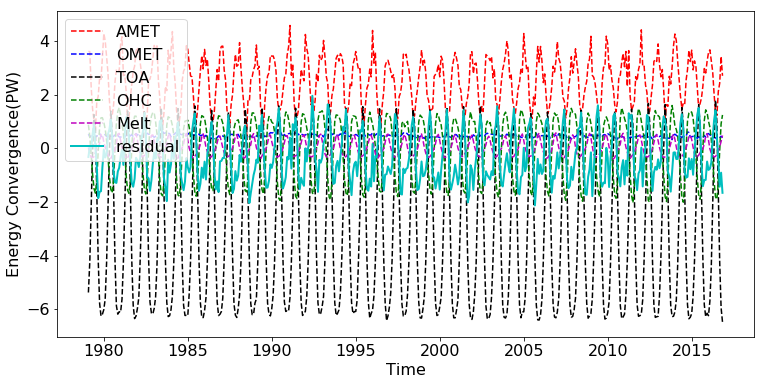

mean of residual
-0.33373048276361816
mean of AMET
2.5176725009464485
mean of OMET
0.4730261916105968
mean of Rtoa
-3.304306799675582
mean of OHC
-0.018901852492012285
mean of SIC
-0.001220433352238227


In [7]:
    print ('*******************  postprocess  *********************')
    print ('***********!@#$%^&*  Energy Budget of ORAS4 - ERAI  !@#$%^&***********')
    print ('======================  AMET & OMET 60N - 90N ========================')
    residual_overall = AMET_int_ERAI_series[1:-1,40] + OMET_int_ORAS4_series[1:-1,53] +\
                       np.sum(net_flux_toa_int_ERAI_area_series[1:-1,:41],1) -\
                       np.sum(OHC_tend_int_ORAS4[1:-1,53:],1) -\
                       np.sum(Heat_SIC_tend_int_ERAI_area[1:-1,53:],1)
    # index for axis
    index_year = np.arange(1980,year_ERAI[-1]+1,5)
    index = np.arange(1,457,1) # 1979 - 2016
    
    fig1 = plt.figure()
    fig1.set_size_inches(12.5, 6)
    plt.plot(index[1:-1], AMET_int_ERAI_series[1:-1,40],'r--',
             linewidth=1.5,label='AMET')
    plt.plot(index[1:-1], OMET_int_ORAS4_series[1:-1,53],'b--',
             linewidth=1.5,label='OMET')
    plt.plot(index[1:-1], np.sum(net_flux_toa_int_ERAI_area_series[1:-1,:41],1),
             'k--', linewidth=1.5, label='TOA')
    plt.plot(index[1:-1], np.sum(-OHC_tend_int_ORAS4[1:-1,53:],1),
             'g--', linewidth=1.5, label='OHC')
    plt.plot(index[1:-1],np.sum(-Heat_SIC_tend_int_ERAI_area[1:-1,53:],1),
             'm--', linewidth=1.5, label='Melt')
    plt.plot(index[1:-1], residual_overall,
             'c-', linewidth=2, label='residual')
    plt.xlabel("Time",fontsize=16)
    plt.xticks(np.arange(13,len(year_ERAI)*12+1,60), index_year,fontsize=16)
    plt.ylabel("Energy Convergence(PW)",fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(frameon=True, loc=2, prop={'size': 16})
    plt.show()
    fig1.savefig(os.path.join(output_path,'energy_budget_overall.png'),dpi=300)
    plt.close(fig1)
    # statistics
    print('mean of residual')
    print(np.mean(residual_overall))
    print('mean of AMET')
    print(np.mean(AMET_int_ERAI_series[1:-1,40]))
    print('mean of OMET')
    print(np.mean(OMET_int_ORAS4_series[1:-1,53]))
    print('mean of Rtoa')
    print(np.mean(np.sum(net_flux_toa_int_ERAI_area_series[1:-1,:41],1)))
    print('mean of OHC')
    print(np.mean(np.sum(-OHC_tend_int_ORAS4[1:-1,53:],1)))
    print('mean of SIC')
    print(np.mean(np.sum(-Heat_SIC_tend_int_ERAI_area[1:-1,53:],1)))
          

*******************  postprocess  *********************
***********!@#$%^&*  Energy Budget of ORAS4 - ERAI  !@#$%^&***********
======================  AMET TOA SFlux 60N - 90N ========================


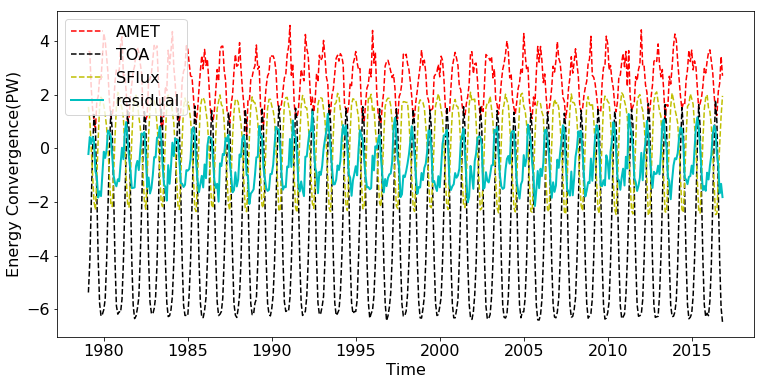

mean of residual
-0.5370628986307123
mean of AMET
2.5176725009464485
mean of Rtoa
-3.304306799675582
mean of SFlux
0.24957149127777367


In [9]:
    print ('*******************  postprocess  *********************')
    print ('***********!@#$%^&*  Energy Budget of ORAS4 - ERAI  !@#$%^&***********')
    print ('======================  AMET TOA SFlux 60N - 90N ========================')
    residual_atmos = AMET_int_ERAI_series[1:-1,40] +\
                     np.sum(net_flux_toa_int_ERAI_area_series[1:-1,:41],1) -\
                     np.sum(net_flux_surf_int_ERAI_area_series[1:-1,:41],1)
    # index for axis
    index_year = np.arange(1980,year_ERAI[-1]+1,5)
    index = np.arange(1,457,1) # 1979 - 2016
    
    fig2 = plt.figure()
    fig2.set_size_inches(12.5, 6)
    plt.plot(index[1:-1], AMET_int_ERAI_series[1:-1,40],'r--',
             linewidth=1.5,label='AMET')
    plt.plot(index[1:-1], np.sum(net_flux_toa_int_ERAI_area_series[1:-1,:41],1),
             'k--', linewidth=1.5, label='TOA')
    plt.plot(index[1:-1], np.sum(-net_flux_surf_int_ERAI_area_series[1:-1,:41],1),
             'y--', linewidth=1.5, label='SFlux')
    plt.plot(index[1:-1], residual_atmos,
             'c-', linewidth=2, label='residual')
    plt.xlabel("Time",fontsize=16)
    plt.xticks(np.arange(13,len(year_ERAI)*12+1,60), index_year,fontsize=16)
    plt.ylabel("Energy Convergence(PW)",fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(frameon=True, loc=2, prop={'size': 16})
    plt.show()
    fig2.savefig(os.path.join(output_path,'energy_budget_atmosphere.png'),dpi=300)
    plt.close(fig2)
    # statistics
    print('mean of residual')
    print(np.mean(residual_atmos))
    print('mean of AMET')
    print(np.mean(AMET_int_ERAI_series[1:-1,40]))
    print('mean of Rtoa')
    print(np.mean(np.sum(net_flux_toa_int_ERAI_area_series[1:-1,:41],1)))    
    print('mean of SFlux')
    print(np.mean(np.sum(-net_flux_surf_int_ERAI_area_series[1:-1,:41],1)))

*******************  postprocess  *********************
***********!@#$%^&*  Energy Budget of ORAS4 - ERAI  !@#$%^&***********
======================  OMET OHC SFlux 60N - 90N ========================


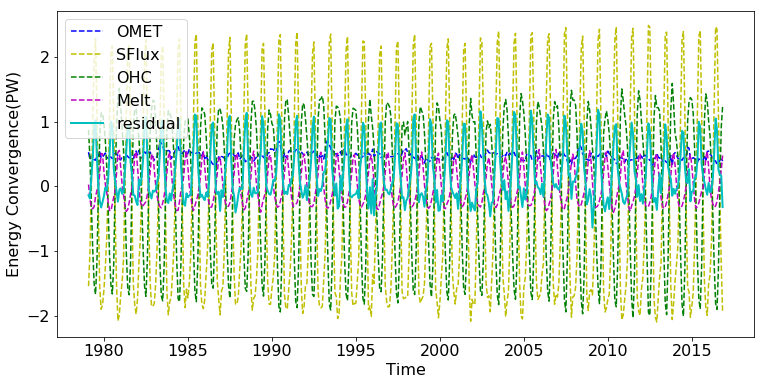

mean of residual
0.20455284784081085


In [10]:
    print ('*******************  postprocess  *********************')
    print ('***********!@#$%^&*  Energy Budget of ORAS4 - ERAI  !@#$%^&***********')
    print ('======================  OMET OHC SFlux 60N - 90N ========================')
    residual_ocean = OMET_int_ORAS4_series[1:-1,53] +\
                     np.sum(net_flux_surf_int_ERAI_area_series[1:-1,:41],1) -\
                     np.sum(OHC_tend_int_ORAS4[1:-1,53:],1)
                     #np.sum(Heat_SIC_tend_int_ERAI_area[1:-1,53:],1)
    # index for axis
    index_year = np.arange(1980,year_ERAI[-1]+1,5)
    index = np.arange(1,457,1) # 1979 - 2016
    fig3 = plt.figure()
    fig3.set_size_inches(12.5, 6)
    plt.plot(index[1:-1], OMET_int_ORAS4_series[1:-1,53],'b--',
             linewidth=1.5,label='OMET')
    plt.plot(index[1:-1], np.sum(net_flux_surf_int_ERAI_area_series[1:-1,:41],1),
             'y--', linewidth=1.5, label='SFlux')
    plt.plot(index[1:-1], np.sum(-OHC_tend_int_ORAS4[1:-1,53:],1),
             'g--', linewidth=1.5, label='OHC')
    plt.plot(index[1:-1],np.sum(-Heat_SIC_tend_int_ERAI_area[1:-1,53:],1),
             'm--', linewidth=1.5, label='Melt')
    plt.plot(index[1:-1], residual_ocean,
             'c-', linewidth=2, label='residual')
    plt.xlabel("Time",fontsize=16)
    plt.xticks(np.arange(13,len(year_ERAI)*12+1,60), index_year,fontsize=16)
    plt.ylabel("Energy Convergence(PW)",fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(frameon=True, loc=2, prop={'size': 16})
    plt.show()
    fig3.savefig(os.path.join(output_path,'energy_budget_ocean.png'),dpi=300)
    plt.close(fig3)
    # statistics
    print('mean of residual')
    print(np.mean(residual_ocean))

In [5]:
    print ('*******************           postprocess           ******************')
    print ('***********!@#$%^&*  Energy Budget of ORAS4 - ERAI  !@#$%^&***********')
    print ('===================  AMET & OMET anomalies 60N-90N  ==================')
    # take anomalies
    stat_AMET_ERAI = meta.statistics.operator(AMET_int_ERAI_series)
    stat_AMET_ERAI.anomaly(Dim_month=False)
    stat_Rtoa_ERAI = meta.statistics.operator(net_flux_toa_int_ERAI_area_series)
    stat_Rtoa_ERAI.anomaly(Dim_month=False)
    stat_SFlux_ERAI = meta.statistics.operator(net_flux_surf_int_ERAI_area_series)
    stat_SFlux_ERAI.anomaly(Dim_month=False)
    stat_SIC_ERAI = meta.statistics.operator(SIC_int_ERAI_area)
    stat_SIC_ERAI.anomaly(Dim_month=False)    
    stat_OMET_ORAS4 = meta.statistics.operator(OMET_int_ORAS4_series)
    stat_OMET_ORAS4.anomaly(Dim_month=False)
    stat_OHC_ORAS4 = meta.statistics.operator(OHC_int_ORAS4_series)
    stat_OHC_ORAS4.anomaly(Dim_month=False)
    # calculate the tendency of OHC anomalies
    OHC_tend_int_anomaly = np.zeros(stat_OHC_ORAS4._anomaly.shape,dtype=float)
    SIC_tend_int_anomaly = np.zeros(stat_SIC_ERAI._anomaly.shape,dtype=float)
    for i in np.arange(len(year_ORAS4)*12-2):
        # skip the first and the last value
        OHC_tend_int_anomaly[i+1,:] = ((stat_OHC_ORAS4._anomaly[i+2,:]
                                     - stat_OHC_ORAS4._anomaly[i,:]) / (2 * 30 * 24 *3600))
        SIC_tend_int_anomaly[i+1,:] = ((stat_SIC_ERAI._anomaly[i+2,:]
                                     - stat_SIC_ERAI._anomaly[i,:]) / (2 * 30 * 24 *3600))
    Heat_SIC_tend_int_anomaly = SIC_tend_int_anomaly * 1.0 * constant['rho_ice'] * 1000 * constant['HoF'] * 1000 / 1E+15 # PW        

*******************           postprocess           ******************
***********!@#$%^&*  Energy Budget of ORAS4 - ERAI  !@#$%^&***********
===================  AMET & OMET anomalies 60N-90N  ==================
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!


*******************           postprocess           ******************
***********!@#$%^&*  Energy Budget of ORAS4 - ERAI  !@#$%^&***********
===================  AMET & OMET anomalies 60N-90N  ==================


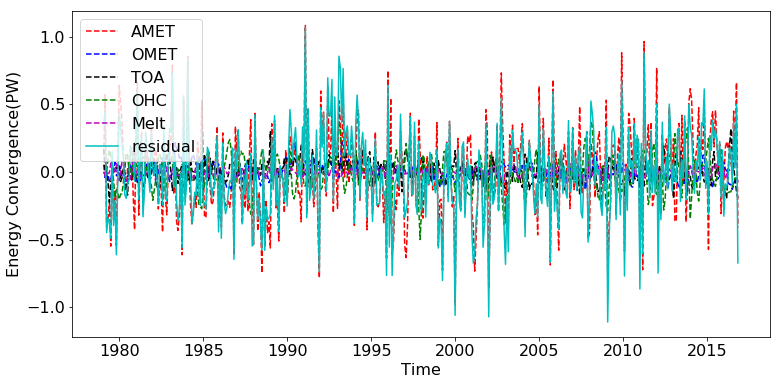

Correlation AMET-Residual
0.8958896614374324
Correlation Rtoa-Residual
0.0664525164960487
Correlation OHC-Residual
0.16869478489038361


In [13]:
    print ('*******************           postprocess           ******************')
    print ('***********!@#$%^&*  Energy Budget of ORAS4 - ERAI  !@#$%^&***********')
    print ('===================  AMET & OMET anomalies 60N-90N  ==================')
    residual_overall_anomaly = stat_AMET_ERAI._anomaly[1:-1,40] + stat_OMET_ORAS4._anomaly[1:-1,53] +\
                               np.sum(stat_Rtoa_ERAI._anomaly[1:-1,:41],1) -\
                               np.sum(OHC_tend_int_anomaly[1:-1,53:],1) -\
                               np.sum(Heat_SIC_tend_int_anomaly[1:-1,53:],1)
    # index for axis
    index_year = np.arange(1980,year_ERAI[-1]+1,5)
    index = np.arange(1,457,1) # 1979 - 2016
    
    fig4 = plt.figure()
    fig4.set_size_inches(12.5, 6)
    plt.plot(index[1:-1], stat_AMET_ERAI._anomaly[1:-1,40],'r--',
             linewidth=1.5,label='AMET')
    plt.plot(index[1:-1], stat_OMET_ORAS4._anomaly[1:-1,53],'b--',
             linewidth=1.5,label='OMET')
    plt.plot(index[1:-1], np.sum(stat_Rtoa_ERAI._anomaly[1:-1,:41],1),
             'k--', linewidth=1.5, label='TOA')
    plt.plot(index[1:-1], np.sum(-OHC_tend_int_anomaly[1:-1,53:],1),
             'g--', linewidth=1.5, label='OHC')
    plt.plot(index[1:-1],np.sum(-Heat_SIC_tend_int_anomaly[1:-1,53:],1),
             'm--', linewidth=1.5, label='Melt')
    plt.plot(index[1:-1], residual_overall_anomaly,
             'c-', linewidth=1.5, label='residual')
    plt.xlabel("Time",fontsize=16)
    plt.xticks(np.arange(13,len(year_ERAI)*12+1,60), index_year,fontsize=16)
    plt.ylabel("Energy Convergence(PW)",fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(frameon=True, loc=2, prop={'size': 16})
    plt.show()
    fig4.savefig(os.path.join(output_path,'energy_budget_overall_anomaly.png'),dpi=300)
    plt.close(fig4)
    # statistics
    print ('Correlation AMET-Residual')
    _, _, Corr_AMET_Res, _, _ = stats.linregress(residual_overall_anomaly,
                                               stat_AMET_ERAI._anomaly[1:-1,40])
    print (Corr_AMET_Res)
    print ('Correlation Rtoa-Residual')
    _, _, Corr_Rtoa_Res, _, _ = stats.linregress(residual_overall_anomaly,
                                                 np.sum(stat_Rtoa_ERAI._anomaly[1:-1,:41],1))
    print (Corr_Rtoa_Res)
    print ('Correlation OHC-Residual')
    _, _, Corr_OHC_Res, _, _ = stats.linregress(residual_overall_anomaly,
                                                np.sum(-OHC_tend_int_anomaly[1:-1,53:],1))
    print (Corr_OHC_Res)

*******************  postprocess  *********************
***********!@#$%^&*  Energy Budget of ORAS4 - ERAI  !@#$%^&***********
======================  AMET TOA SFlux anomalies 60N - 90N ========================


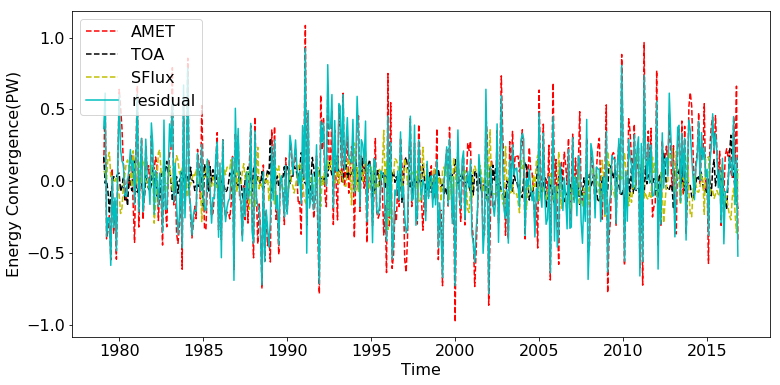

mean of residual
-2.85859156521165e-05
Correlation AMET-Residual
0.8990307841203034
Correlation Rtoa-Residual
0.08476455094144089
Correlation SFlux-Residual
-0.018992910512876552


In [7]:
    print ('*******************  postprocess  *********************')
    print ('***********!@#$%^&*  Energy Budget of ORAS4 - ERAI  !@#$%^&***********')
    print ('======================  AMET TOA SFlux anomalies 60N - 90N ========================')
    residual_atmos_anomaly = stat_AMET_ERAI._anomaly[1:-1,40] +\
                             np.sum(stat_Rtoa_ERAI._anomaly[1:-1,:41],1) -\
                             np.sum(stat_SFlux_ERAI._anomaly[1:-1,:41],1)
    # index for axis
    index_year = np.arange(1980,year_ERAI[-1]+1,5)
    index = np.arange(1,457,1) # 1979 - 2016
    
    fig5 = plt.figure()
    fig5.set_size_inches(12.5, 6)
    plt.plot(index[1:-1], stat_AMET_ERAI._anomaly[1:-1,40],'r--',
             linewidth=1.5,label='AMET')
    plt.plot(index[1:-1], np.sum(stat_Rtoa_ERAI._anomaly[1:-1,:41],1),
             'k--', linewidth=1.5, label='TOA')
    plt.plot(index[1:-1], np.sum(-stat_SFlux_ERAI._anomaly[1:-1,:41],1),
             'y--', linewidth=1.5, label='SFlux')
    plt.plot(index[1:-1], residual_atmos_anomaly,
             'c-', linewidth=1.5, label='residual')
    plt.xlabel("Time",fontsize=16)
    plt.xticks(np.arange(13,len(year_ERAI)*12+1,60), index_year,fontsize=16)
    plt.ylabel("Energy Convergence(PW)",fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(frameon=True, loc=2, prop={'size': 16})
    plt.show()
    fig5.savefig(os.path.join(output_path,'energy_budget_atmosphere_anomaly.png'),dpi=300)
    plt.close(fig5)
    
    print('mean of residual')
    print(np.mean(residual_atmos_anomaly))
    print ('Correlation AMET-Residual')
    _, _, Corr_AMET_Res, _, _ = stats.linregress(residual_atmos_anomaly,
                                               stat_AMET_ERAI._anomaly[1:-1,40])
    print (Corr_AMET_Res)
    print ('Correlation Rtoa-Residual')
    _, _, Corr_Rtoa_Res, _, _ = stats.linregress(residual_atmos_anomaly,
                                                 np.sum(stat_Rtoa_ERAI._anomaly[1:-1,:41],1))
    print (Corr_Rtoa_Res)
    print ('Correlation SFlux-Residual')
    _, _, Corr_Rtoa_Res, _, _ = stats.linregress(residual_atmos_anomaly,
                                                 np.sum(-stat_SFlux_ERAI._anomaly[1:-1,:41],1))
    print (Corr_Rtoa_Res)

*******************  postprocess  *********************
***********!@#$%^&*  Energy Budget of ORAS4 - ERAI  !@#$%^&***********
======================  OMET OHC SFlux anomalies 60N - 90N ========================


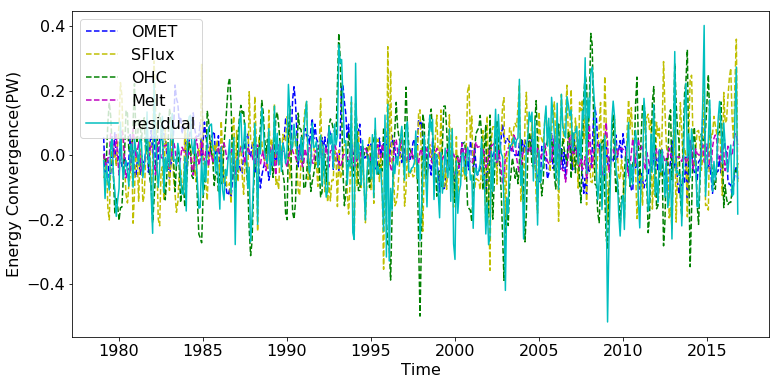

In [15]:
    print ('*******************  postprocess  *********************')
    print ('***********!@#$%^&*  Energy Budget of ORAS4 - ERAI  !@#$%^&***********')
    print ('======================  OMET OHC SFlux anomalies 60N - 90N ========================')
    residual_ocean_anomaly = stat_OMET_ORAS4._anomaly[1:-1,53] +\
                             np.sum(stat_SFlux_ERAI._anomaly[1:-1,:41],1) -\
                             np.sum(OHC_tend_int_anomaly[1:-1,53:],1)
                             #np.sum(Heat_SIC_tend_int_anomaly[1:-1,53:],1)
    # index for axis
    index_year = np.arange(1980,year_ERAI[-1]+1,5)
    index = np.arange(1,457,1) # 1979 - 2016
    fig6 = plt.figure()
    fig6.set_size_inches(12.5, 6)
    plt.plot(index[1:-1], stat_OMET_ORAS4._anomaly[1:-1,53],'b--',
             linewidth=1.5,label='OMET')
    plt.plot(index[1:-1], np.sum(stat_SFlux_ERAI._anomaly[1:-1,:41],1),
             'y--', linewidth=1.5, label='SFlux')
    plt.plot(index[1:-1], np.sum(-OHC_tend_int_anomaly[1:-1,53:],1),
             'g--', linewidth=1.5, label='OHC')
    plt.plot(index[1:-1],np.sum(-Heat_SIC_tend_int_anomaly[1:-1,53:],1),
             'm--', linewidth=1.5, label='Melt')
    plt.plot(index[1:-1], residual_ocean_anomaly,
             'c-', linewidth=1.5, label='residual')
    plt.xlabel("Time",fontsize=16)
    plt.xticks(np.arange(13,len(year_ERAI)*12+1,60), index_year,fontsize=16)
    plt.ylabel("Energy Convergence(PW)",fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(frameon=True, loc=2, prop={'size': 16})
    plt.show()
    fig6.savefig(os.path.join(output_path,'energy_budget_ocean_anomaly.png'),dpi=300)
    plt.close(fig3)

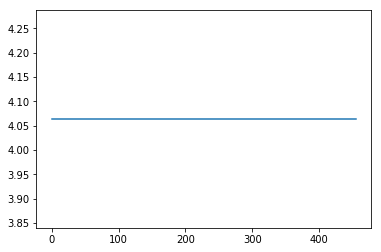

In [6]:
    # Estimation of the possible leakage of energy given by ECMWF
    # Berriford et. al. 2011. Atmospheric conservation properties in ERA-Interim.
    # Check for the residual of 8 PW and its contribution in the Arctic (60N -90N)
    residual_ECMWF_ERAI = np.ones(net_flux_toa_ERAI.shape, dtype=float)
    residual_ECMWF_ERAI_area = np.zeros(net_flux_toa_ERAI.shape, dtype=float)
    #size of the grid box
    for i in np.arange(len(latitude_fields_ERAI)):
        # change the unit to terawatt
        residual_ECMWF_ERAI_area[:,:,i,:] = residual_ECMWF_ERAI[:,:,i,:] * 8 * dx[i] * dy / 1E+12
    # take the zonal integral
    residual_ECMWF_int_ERAI_area = np.sum(residual_ECMWF_ERAI_area,3)
    residual_ECMWF_int_ERAI_area_series = residual_ECMWF_int_ERAI_area.reshape(len(year_ERAI)*12,
                                                                               len(latitude_fields_ERAI))
    plt.plot(np.sum(residual_ECMWF_int_ERAI_area_series[:,:],1)/1000)

-4.305690232524865


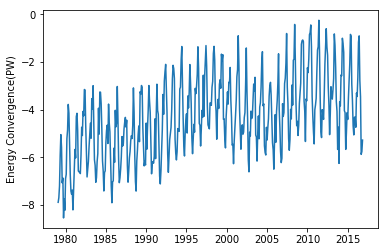

In [21]:
    # Estimation of the possible leakage of energy given by ECMWF
    # Global mean of TOA - SFlux
    residual_global_atmos = np.sum(net_flux_toa_int_ERAI_area_series[1:-1,:],1) -\
                            np.sum(net_flux_surf_int_ERAI_area_series[1:-1,:],1)
    plt.plot(index[1:-1], residual_global_atmos)
    plt.xticks(np.arange(13,len(year_ERAI)*12+1,60), index_year)
    plt.ylabel("Energy Convergence(PW)")
    
    print (np.mean(residual_global_atmos))

*******************           postprocess           ******************
***********!@#$%^&*  Energy Budget of ORAS4 - ERAI  !@#$%^&***********
===================  AMET & OMET anomalies 60N-90N lowpass 5 year  ==================
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!


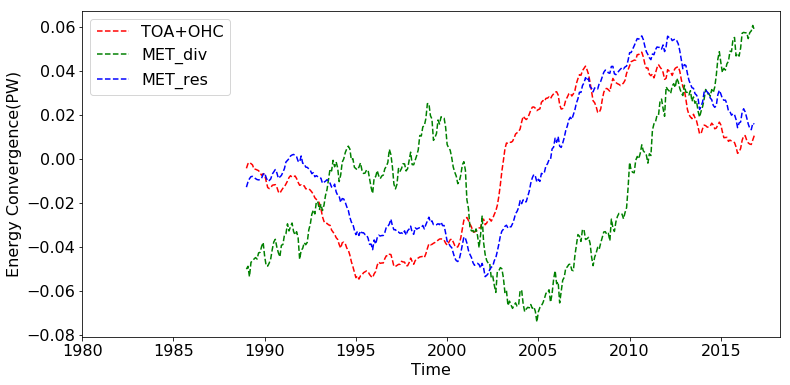

In [8]:
    print ('*******************           postprocess           ******************')
    print ('***********!@#$%^&*  Energy Budget of ORAS4 - ERAI  !@#$%^&***********')
    print ('===================  AMET & OMET anomalies 60N-90N lowpass 5 year  ==================')
    AMET_residual = -(np.sum(net_flux_toa_int_ERAI_area_series[1:-1,:41],1) - 
                      np.sum(net_flux_surf_int_ERAI_area_series[1:-1,:41],1))
    TOA_OHC = np.sum(net_flux_toa_int_ERAI_area_series[1:-1,:41],1) - np.sum(OHC_tend_int_ORAS4[1:-1,53:],1)
    MET_sum_div = AMET_int_ERAI_series[1:-1,40] + OMET_int_ORAS4_series[1:-1,53]
    MET_sum_res = AMET_residual + OMET_int_ORAS4_series[1:-1,53]
    # take the running mean
    stat_TOA_OHC = meta.statistics.operator(-TOA_OHC)
    stat_TOA_OHC.anomaly(Dim_month=False)
    stat_TOA_OHC.lowpass(window=120)
    stat_MET_div = meta.statistics.operator(MET_sum_div)
    stat_MET_div.anomaly(Dim_month=False)
    stat_MET_div.lowpass(window=120)
    stat_MET_res = meta.statistics.operator(MET_sum_res)
    stat_MET_res.anomaly(Dim_month=False)
    stat_MET_res.lowpass(window=120)
    # index for axis
    index_year = np.arange(1980,year_ERAI[-1]+1,5)
    index = np.arange(1,457,1) # 1979 - 2016
    
    fig7 = plt.figure()
    fig7.set_size_inches(12.5, 6)
    plt.plot(index[120:-1], stat_TOA_OHC._lowpass,'r--',
             linewidth=1.5,label='TOA+OHC')
    plt.plot(index[120:-1], stat_MET_div._lowpass,
             'g--', linewidth=1.5, label='MET_div')
    plt.plot(index[120:-1], stat_MET_res._lowpass,'b--',
             linewidth=1.5,label='MET_res')
    plt.xlabel("Time",fontsize=16)
    plt.xticks(np.arange(13,len(year_ERAI)*12+1,60), index_year,fontsize=16)
    plt.ylabel("Energy Convergence(PW)",fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(frameon=True, loc=2, prop={'size': 16})
    plt.show()
    fig7.savefig(os.path.join(output_path,'bjerknes_anomaly_lowpass_10y.png'),dpi=300)
    plt.close(fig7)

*******************           postprocess           ******************
***********!@#$%^&*  Energy Budget of ORAS4 - ERAI  !@#$%^&***********
=================  AMET res & OMET anomalies 60N-90N  ================
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!


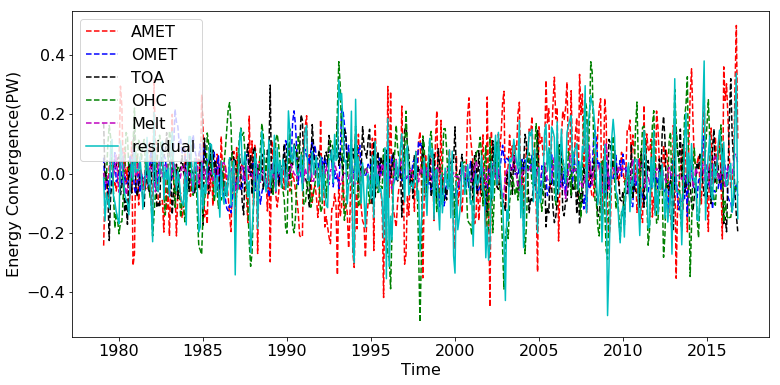

Correlation AMET-Residual
0.37774570966051463
Correlation OMET-Residual
0.17524687193403318
Correlation Rtoa-Residual
-0.029693957646603087
Correlation OHC-Residual
0.4390643255090225
Correlation Melt-Residual
0.158315488900167


In [9]:
    print ('*******************           postprocess           ******************')
    print ('***********!@#$%^&*  Energy Budget of ORAS4 - ERAI  !@#$%^&***********')
    print ('=================  AMET res & OMET anomalies 60N-90N  ================')
    
    stat_AMET_res = meta.statistics.operator(AMET_residual)
    stat_AMET_res.anomaly(Dim_month=False)
    residual_overall_anomaly_new = stat_AMET_res._anomaly[:] +\
                                   stat_OMET_ORAS4._anomaly[1:-1,53] +\
                                   np.sum(stat_Rtoa_ERAI._anomaly[1:-1,:41],1) -\
                                   np.sum(OHC_tend_int_anomaly[1:-1,53:],1) -\
                                   np.sum(Heat_SIC_tend_int_anomaly[1:-1,53:],1)
    # index for axis
    index_year = np.arange(1980,year_ERAI[-1]+1,5)
    index = np.arange(1,457,1) # 1979 - 2016
    
    fig8 = plt.figure()
    fig8.set_size_inches(12.5, 6)
    plt.plot(index[1:-1], stat_AMET_res._anomaly[:],'r--',
             linewidth=1.5,label='AMET')
    plt.plot(index[1:-1], stat_OMET_ORAS4._anomaly[1:-1,53],'b--',
             linewidth=1.5,label='OMET')
    plt.plot(index[1:-1], np.sum(stat_Rtoa_ERAI._anomaly[1:-1,:41],1),
             'k--', linewidth=1.5, label='TOA')
    plt.plot(index[1:-1], np.sum(-OHC_tend_int_anomaly[1:-1,53:],1),
             'g--', linewidth=1.5, label='OHC')
    plt.plot(index[1:-1],np.sum(-Heat_SIC_tend_int_anomaly[1:-1,53:],1),
             'm--', linewidth=1.5, label='Melt')
    plt.plot(index[1:-1], residual_overall_anomaly_new,
             'c-', linewidth=1.5, label='residual')
    plt.xlabel("Time",fontsize=16)
    plt.xticks(np.arange(13,len(year_ERAI)*12+1,60), index_year,fontsize=16)
    plt.ylabel("Energy Convergence(PW)",fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(frameon=True, loc=2, prop={'size': 16})
    plt.show()
    fig8.savefig(os.path.join(output_path,'energy_budget_overall_anomaly_AMET_res.png'),dpi=300)
    plt.close(fig8)
    # statistics
    print ('Correlation AMET-Residual')
    _, _, Corr_AMET_Res, _, _ = stats.linregress(residual_overall_anomaly_new,
                                                 stat_AMET_res._anomaly)
    print (Corr_AMET_Res)
    print ('Correlation OMET-Residual')
    _, _, Corr_OMET_Res, _, _ = stats.linregress(residual_overall_anomaly_new,
                                                 stat_OMET_ORAS4._anomaly[1:-1,53])
    print (Corr_OMET_Res)
    print ('Correlation Rtoa-Residual')
    _, _, Corr_Rtoa_Res, _, _ = stats.linregress(residual_overall_anomaly_new,
                                                 np.sum(stat_Rtoa_ERAI._anomaly[1:-1,:41],1))
    print (Corr_Rtoa_Res)
    print ('Correlation OHC-Residual')
    _, _, Corr_OHC_Res, _, _ = stats.linregress(residual_overall_anomaly_new,
                                                np.sum(-OHC_tend_int_anomaly[1:-1,53:],1))
    print (Corr_OHC_Res)
    print ('Correlation Melt-Residual')
    _, _, Corr_Melt_Res, _, _ = stats.linregress(residual_overall_anomaly_new,
                                                 np.sum(-Heat_SIC_tend_int_anomaly[1:-1,53:],1))
    print (Corr_Melt_Res)